# Test: Africa data
- Import excel file, add date column and export it as json. Use json file for analysis
- Data formatting: column names 
- Filter data since 2010
- Function to plot specific country
- Encode event_type and sub_event_type
- Aggregate by month. Working dataset for ML
- Test K-Clustering

In [1]:
# African dataset
# https://www.acleddata.com/curated-data-files/

In [33]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Exporting excel file as json

In [4]:
# # import excel file
# df = pd.read_excel('../data/Africa_1997-2019_Oct12-1.xlsx')

In [5]:
# # New column for date & month
# df['date'] = pd.to_datetime(df['EVENT_DATE']).dt.date

In [6]:
# # export dataframe as json
# df.to_json('../data/africa-data.json')

## Importing data

In [7]:
df = pd.read_json('../data/africa-data.json')

In [8]:
df.shape

(193565, 30)

In [9]:
# df.head()

## Data cleaning
- Rename columns
- Encode values
- Define classification according to event/fatalities?

In [10]:
# Rename and remove columns
columns = ['YEAR', 'EVENT_TYPE', 'SUB_EVENT_TYPE', 'ACTOR1', 'REGION', 'COUNTRY', 'SOURCE', 'FATALITIES', 'date']
try:
    df = df[columns]
    df.columns = ['year', 'event_type', 'sub_event_type', 'actor', 'region', 'country', 'source', 'fatalities', 'date']
except KeyError as e:
    print(e)
    pass

print(df.columns)
print(df.shape)

Index(['year', 'event_type', 'sub_event_type', 'actor', 'region', 'country', 'source', 'fatalities', 'date'], dtype='object')
(193565, 9)


In [11]:
# Encode event_types and sub_event_types
# https://www.datacamp.com/community/tutorials/categorical-data

In [12]:
# print('**Categorical values**\n')
# print('{} event types:\n {}\n'.format(df.event_type.nunique(), df.event_type.unique()))
# print('{} sub_event types:\n {}\n'.format(df.sub_event_type.nunique(), df.sub_event_type.unique()))
# print('{} actors:\n {}\n'.format(df.actor.nunique(), df.actor.unique()))
# print('{} countries:\n {}\n'.format(df.country.nunique(), df.country.unique()))

## Plot all data

In [13]:
# Include data since 2010
filtered_data = df[df.year > 2009]
filtered_data['year'].unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

In [14]:
incidents = filtered_data.groupby(['date'])['event_type'].count()
incidents.head()

date
2010-01-01    22
2010-01-02     9
2010-01-03    12
2010-01-04    25
2010-01-05    23
Name: event_type, dtype: int64

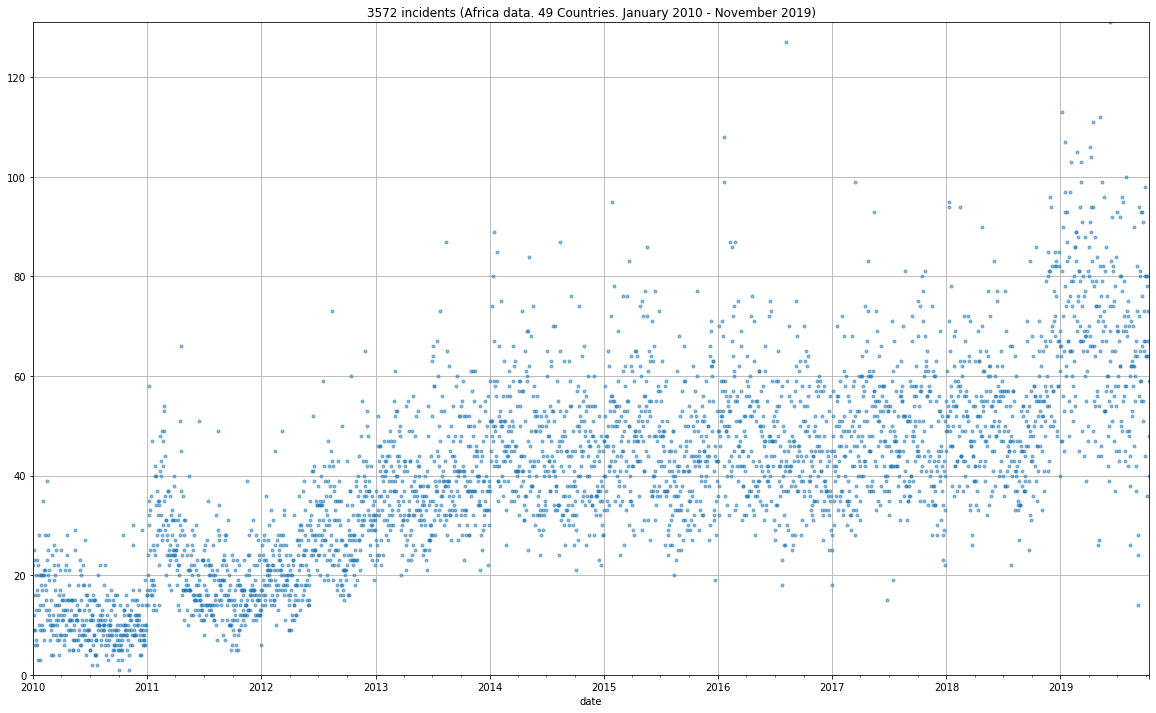

In [15]:
# Time series plots
# https://preinventedwheel.com/easy-python-time-series-plots-with-matplotlib/

plt.rcParams['figure.figsize'] = (20, 12)
incidents.plot(style ='.', alpha = 0.5)\
    .set_ylim(0,incidents.values.max())

plt.grid()

plt.title('{} incidents (Africa data. {} Countries. January 2010 - November 2019)'\
           .format(incidents.count(), filtered_data.country.nunique()))

plt.show()

## Plot country data

In [16]:
# Pivot table: all data by country, year, event count

all_countries = filtered_data.groupby(['year', 'country'])['event_type'].count().\
                reset_index(level=['year','country'])

all_countries = pd.pivot_table(all_countries, index= 'year', columns='country', values = 'event_type')


In [17]:
# print(worst_country.loc[worst_country['event_type'].idxmax()])
# # print('\n')
# # print(worst_country.loc[worst_country['event_type'].min()])
# print(worst_country.loc[worst_country['event_type'].max(level = 'year')])

In [18]:
#Function to get data for one specific country.
# Plot data in a timeline. 

def country_data(data, name_country = ""):
    global df_country
    try:
        #Query and group data by specified country
        df_country = data.query('country == "{}"'.format(name_country))      
        fatalities = df_country.groupby(['date'])['fatalities'].sum()  
        event_type = df_country.groupby(['date'])['event_type'].count()
                
        #matplotlib graph: All cases over time, rolling for country & total
        plt.rcParams['figure.figsize'] = (20, 12)        
        all_countries.plot(subplots=False, style='-', alpha=0.2, color = 'gray')
        all_countries[name_country].plot(subplots=False, style='--', linewidth = 2, alpha=1, color = 'r')
        plt.legend().remove()
        
        print('\n(Data from {} countries)'.format(all_countries.index.nunique()))

        plt.title('{} of events in {} ({} fatalities) (2010 - 2019)\n'.\
              format(df_country['event_type'].count(), name_country, df_country.fatalities.sum()))
        
        plt.xlabel('Tears')
        plt.ylabel('Fatalities')

              
    except (NameError, KeyError) as e:
        print('Error: {}'.format(e))
        plt.legend().remove()
        pass



(Data from 10 countries)


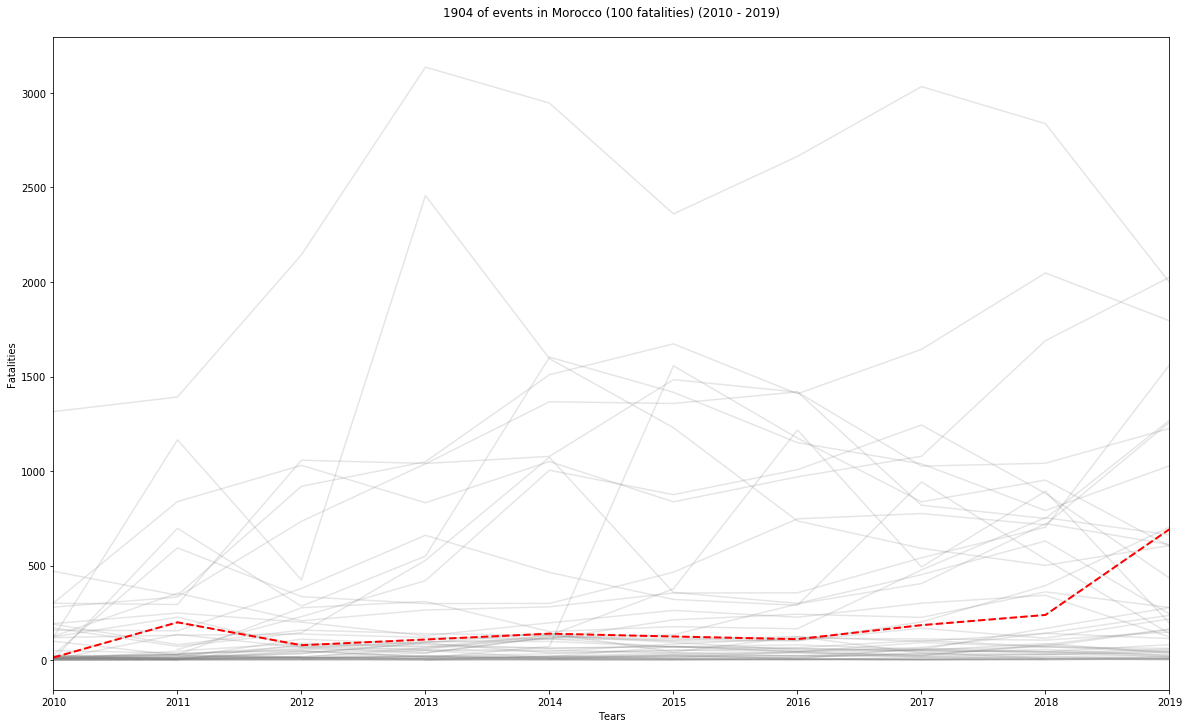

In [39]:
country_data(filtered_data, 'Morocco')

# K-Clustering

In [20]:
# Adding a boolean column for fatalities
filtered_data['fatalities_encoded'] = np.where(filtered_data['fatalities']>0, '1', '0')

/Users/cms/Sites/env/data/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [21]:
# Selecting labels for one-hot encoding
labels = ['event_type','country']
labels = filtered_data[labels]
labels.head()

,event_type,country
10050,Violence against civilians,Angola
10051,Battles,Angola
10052,Violence against civilians,Angola
10053,Violence against civilians,Angola
10054,Violence against civilians,Angola


In [22]:
# One-Hot Encoding with get_dummies
labels_encoded = pd.get_dummies(labels)

In [23]:
labels_encoded.shape

(143354, 55)

In [24]:
filtered_data = pd.concat([filtered_data, labels_encoded], axis = 1, sort = False)
# filtered_data.iloc[1]

## Functions

In [29]:
# Function to select number of clusters
# Using k-means

def n_clusters(data, number, title_dataset = ''):
    n_cluster = range(1, number)
    kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
    scores = [kmeans[i].score(data) for i in range(len(kmeans))]
    
    fig, ax = plt.subplots(figsize=(10,7))
    ax.plot(n_cluster, scores)
    plt.xlabel('Number of Clusters: {}'.format(title_dataset))
    plt.ylabel('Score')
    plt.title('Elbow Curve')
    plt.show()
    
    return scores
    

In [30]:
# Function to assigng clusters
def clustering(data, number_clusters):
    clusters = KMeans(n_clusters=number_clusters)    
    clusters.fit(data)
    data['labels'] = clusters.predict(data)
    
    return print('Labels: {}'.format(data.labels.value_counts()))
                    

In [31]:
def plot_labels(data):
    plt.rcParams['figure.figsize'] = (16, 10)
    # plt.scatter(filtered_data.date, filtered_data.country, c=filtered_data.labels, alpha = 0.1)
    
    plt.scatter(data.date, data.labels, c=data.labels, alpha = 0.1)
    plt.grid()
    plt.title('Distribution of labels by years in {}'\
           .format(data.country.unique()))
    
#     sns.boxplot(x='date', y='labels', data=data)
    
    plt.show()

## K-clustering data from one country

In [25]:
senegal = filtered_data.query('country == "Senegal"')

In [27]:
# Select X values 
n_senegal = len(senegal.columns)
X_senegal = senegal.iloc[:,np.r_[0, 9:n_senegal]] #removing number of fatalities

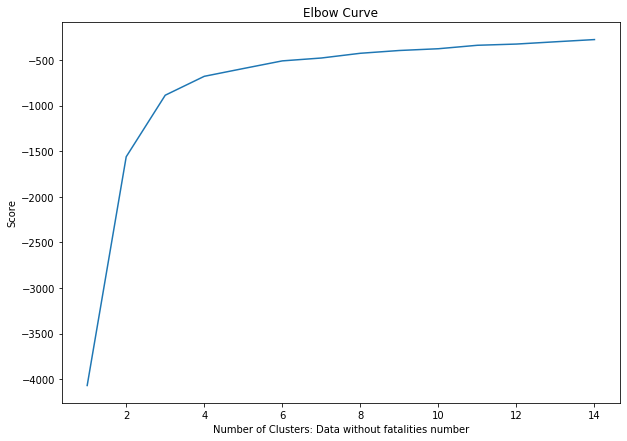

[-4070.2603176385164,
 -1561.7571871662512,
 -886.9057422289625,
 -679.6568334884942,
 -594.4354131761938,
 -510.40363364620134,
 -478.92603990621865,
 -427.01367731951177,
 -396.4638403477147,
 -377.14011934399605,
 -339.2635174258612,
 -325.8913550898433,
 -300.97926207864657,
 -276.72580036893487]

In [34]:
n_clusters(X_senegal, 15, "Data without fatalities number")

In [35]:
clustering(X_senegal, 9)

Labels: 2    107
1     87
7     83
6     82
4     80
5     64
3     52
8     46
0     29
Name: labels, dtype: int64


/Users/cms/Sites/env/data/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [36]:
senegal['labels'] = X_senegal.labels

/Users/cms/Sites/env/data/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


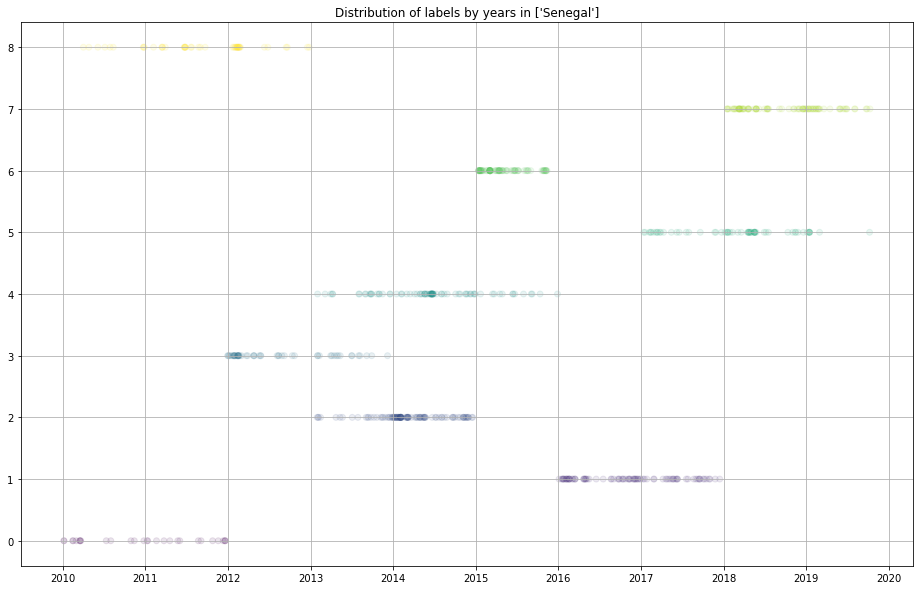

In [37]:
plot_labels(senegal)